# Validation Map Generation

This notebook creates validation maps by overlaying ground truth points on drone imagery from the Upper Partridge survey area. The maps show the spatial distribution of horse presence/absence observations, helping to validate our survey methodology and understand horse distribution patterns.

## Key Features
- Overlays ground truth points on high-resolution drone imagery
- Color-codes points by presence (green) and absence (red)
- Includes automatic downsampling for efficient visualization
- Supports both display and saving of generated maps

# Setup

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.enums import Resampling
import argparse
import numpy as np

## Map Generation Function
Define the core function that creates validation maps by combining drone imagery with ground truth points. The function handles:
- Loading and processing drone imagery
- Overlaying ground truth points
- Customizing visualization parameters
- Saving and displaying results

In [4]:
def create_validation_map(
    geotiff_path,
    groundtruth_path,
    output_path=None,
    downsample_factor=8,
    display=False,
    save=False,
):
    """
    Create a validation map showing ground truth points overlaid on drone imagery.

    Args:
        geotiff_path (str): Path to the drone survey GeoTIFF
        groundtruth_path (str): Path to the ground truth GeoJSON file
        output_path (str, optional): Path to save the output figure. If None, uses default path.
        downsample_factor (int): Factor by which to downsample the raster. Higher values = smaller image.
        display (bool): Whether to display the figure
        save (bool): Whether to save the figure
    """
    # Read the ground truth points
    gdf = gpd.read_file(groundtruth_path)
    if len(gdf) == 0:
        raise ValueError("No points found in ground truth file")

    # Create figure and axis with a larger size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Extract survey name from geotiff path (digits only)
    survey_name = "".join(filter(str.isdigit, os.path.basename(geotiff_path)))

    # Read and plot the drone imagery with decimation
    with rio.open(geotiff_path) as src:
        # Calculate new shape
        height = int(src.height // downsample_factor)
        width = int(src.width // downsample_factor)

        # Read decimated raster
        data = src.read(
            out_shape=(src.count, height, width), resampling=Resampling.average
        )

        # Check if we got valid data
        if data.size == 0 or np.all(data == 0):
            raise ValueError("No valid data read from GeoTIFF")

        # Scale image transform
        transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]), (src.height / data.shape[-2])
        )

        # Ensure ground truth points are in same CRS as raster
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Plot the raster
        show(data, transform=transform, ax=ax)

    # Plot points with different colors for presence/absence
    presence = gdf[gdf["Presence"] == 1]
    absence = gdf[gdf["Presence"] == 0]

    print(f"Plotting {len(presence)} presence points and {len(absence)} absence points")

    # Plot presence points
    ax.scatter(
        presence.geometry.x,
        presence.geometry.y,
        c="green",
        s=10,  # size
        alpha=0.5,
        label="Present",
        edgecolor="white",
        linewidth=0.5,
    )

    # Plot absence points
    ax.scatter(
        absence.geometry.x,
        absence.geometry.y,
        c="red",
        s=10,  # size
        alpha=0.5,
        label="Absent",
        edgecolor="white",
        linewidth=0.5,
    )

    # Customize the plot
    ax.grid(True, alpha=0.5)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title(f"Upper Partridge Survey: {survey_name}")
    ax.legend()

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Handle display and save
    try:
        if save:
            if output_path is None:
                output_path = os.path.join(
                    "figures", f"validation_map_{survey_name}.png"
                )

            # Create output directory if it doesn't exist
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Save figure
            print(f"Saving figure to {output_path}")
            fig.savefig(
                output_path,
                dpi=150,
                bbox_inches="tight",
                facecolor="white",  # Ensure white background
            )

        if display:
            plt.show()
    finally:
        plt.close(fig)

## Generate Validation Map
Create a validation map using the Upper Partridge survey data. The map will show:
- Base layer: Drone imagery from the survey
- Overlay: Ground truth points color-coded by horse presence/absence
- Grid lines for spatial reference
- Legend identifying point types

The map can be:
- Displayed in the notebook using display=True
- Saved to file using save=True (default path: figures/validation_map_{survey_name}.png)

Plotting 884 presence points and 716 absence points


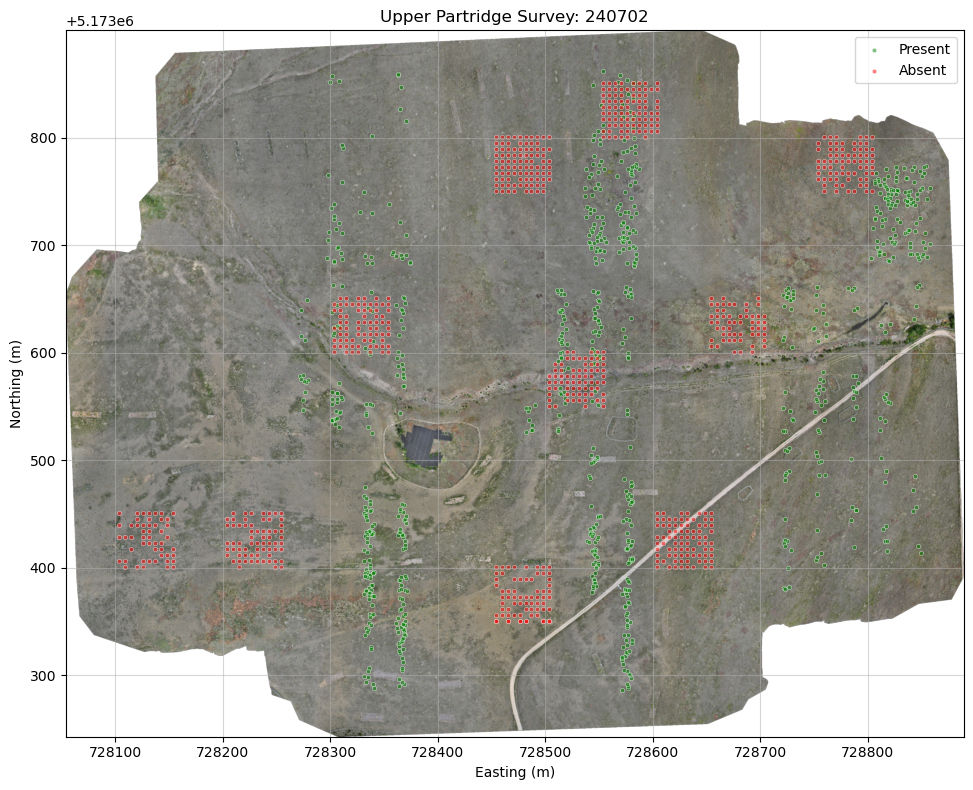

In [6]:
# Set up parameters
geotiff_path = os.path.join("../data", "raster", "geotiffs", "240702_upperpartridge-visible.tif")
groundtruth_path = os.path.join("../data", "vector", "groundtruth.geojson")

# Create and display the map
create_validation_map(
    geotiff_path=geotiff_path,
    groundtruth_path=groundtruth_path,
    downsample_factor=20,  # Adjust this value to change image resolution
    display=True,  # Show the plot in the notebook
    save=False  # Also save the plot to file
)